Import necessary libraries:

In [ ]:
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5' # Use physical GPU 5
import sys
print(f"Python Executable: {sys.executable}")

import jax
import jax.lib
import jax.numpy as jnp
from jax import grad, jit
from jax.nn import initializers
import matplotlib.pyplot as plt
from functools import partial
import time
import copy
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

a = 1

# --- JAX Environment Check ---
print(f"JAX version: {jax.__version__}")
print(f"jaxlib version: {jax.lib.__version__}")
backend = jax.default_backend()
print(f"Default backend: {backend}")
print(f"Available devices: {jax.devices()}")

if backend == 'cpu':
    print("\n*** WARNING: JAX is running on CPU. ***")
    print("To enable GPU, ensure a CUDA-enabled version of jaxlib is installed.")
    print("Example: pip install --upgrade \"jax[cuda12_pip]\"] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

Python Executable: C:\Users\kiril\miniconda3\python.exe
JAX version: 0.4.35
jaxlib version: 0.4.35
Default backend: cpu
Available devices: [CpuDevice(id=0)]

*** WARNING: JAX is running on CPU. ***
To enable GPU, ensure a CUDA-enabled version of jaxlib is installed.
Example: pip install --upgrade "jax[cuda12_pip]"] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


We now want the functions needed for training, which use jax architecture.

In [32]:
def init_network_params(layer_dims, key):
    keys = jax.random.split(key, len(layer_dims) - 1)
    params = []
    for i, (in_dim, out_dim) in enumerate(zip(layer_dims[:-1], layer_dims[1:])):
        W = initializers.glorot_normal()(keys[i], (in_dim, out_dim))
        b = initializers.zeros(keys[i], (out_dim,))
        params.append((W, b))
    return params


@jit
def jax_relu(x):
    return jnp.maximum(0, x)


def jax_softmax(x, axis=-1):
    x_max = jnp.max(x, axis=axis, keepdims=True)
    exp_x = jnp.exp(x - x_max)
    return exp_x / jnp.sum(exp_x, axis=axis, keepdims=True)

def jax_forward(params, x):
    activation = x
    for i, (W, b) in enumerate(params[:-1]):
        outputs = jnp.dot(activation, W) + b
        activation = jax_relu(outputs)
    final_W, final_b = params[-1]
    # For regression, the final output is linear (no activation)
    final_outputs = jnp.dot(activation, final_W) + final_b
    return final_outputs

def jax_update_params(params, grads, lr):
    return [(W - lr * dW, b - lr * db) for (W, b), (dW, db) in zip(params, grads)]

@jit
def jax_compute_mse_loss(params, x_batch, y_batch_reg):
    """Computes Mean Squared Error for regression."""
    predictions = jax_forward(params, x_batch)
    error = predictions - y_batch_reg
    return jnp.mean(error**2)

jax_loss_grad_fn = jit(grad(jax_compute_mse_loss, argnums=0))

def compute_rmse_jax(params, x, y_reg):
    """Computes Root Mean Squared Error for regression."""
    mse_loss = jax_compute_mse_loss(params, x, y_reg)
    return jnp.sqrt(mse_loss)

Flatten and unflatten parameters, get shape and type of unflattened parameters:

In [33]:
def flatten_params(params_list):
    flat_params_leaves, treedef = jax.tree_util.tree_flatten(params_list)
    flat_params_leaves = [jnp.asarray(leaf) for leaf in flat_params_leaves]
    return jnp.concatenate([p.ravel() for p in flat_params_leaves]), treedef

def unflatten_params(flat_params_vec, treedef, shapes_and_dtypes_meta):
    leaves = []
    current_pos = 0
    for shape, dtype in shapes_and_dtypes_meta:
        num_elements = np.prod(shape, dtype=int)
        leaves.append(jnp.asarray(flat_params_vec[current_pos: current_pos + num_elements], dtype=dtype).reshape(shape))
        current_pos += num_elements
    return jax.tree_util.tree_unflatten(treedef, leaves)

def get_shapes_and_dtypes(params_list):
    flat_params_meta, _ = jax.tree_util.tree_flatten(params_list)
    return [(p.shape, p.dtype) for p in flat_params_meta]

Helper function to compute parameter difference norm:

In [34]:
def compute_params_diff_norm(params1, params2):
    """Computes the Frobenius norm of the difference between two parameter lists."""
    diff_norms_sq = [
        jnp.sum((w1 - w2)**2) + jnp.sum((b1 - b2)**2)
        for (w1, b1), (w2, b2) in zip(params1, params2)
    ]
    return jnp.sqrt(jnp.sum(jnp.array(diff_norms_sq)))

Forward unflattened parameters:

In [35]:
def single_sample_forward_flat_params(flat_params_vec, single_x_input, treedef, shapes_and_dtypes_meta):
    unflattened_params_list = unflatten_params(flat_params_vec, treedef, shapes_and_dtypes_meta)
    return jax_forward(unflattened_params_list, single_x_input.reshape(1, -1))[0]

Run SGD training:

In [36]:
def run_sgd_epochs(params_initial, X_train_sgd, Y_train_reg_sgd, X_val_full, Y_val_reg_full,
                   start_epoch_idx, num_epochs_to_run, # start_epoch_idx is 0-based
                   batch_size, lr_sgd, key_sgd_loop, phase_label="SGD"):
    print(f"\n--- Starting {phase_label} Training Phase (Epochs {start_epoch_idx + 1} to {start_epoch_idx + num_epochs_to_run}) ---")
    params = params_initial # Start from provided parameters
    N_train_sgd = X_train_sgd.shape[0]
    
    # Calculate means over the full datasets for stable normalization
    y_train_mean = jnp.mean(Y_train_reg_sgd)
    y_val_mean = jnp.mean(Y_val_reg_full)
    
    history = {'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}

    sgd_phase_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)

    for epoch_offset in range(num_epochs_to_run):
        actual_epoch_num_display = start_epoch_idx + epoch_offset + 1 # For printing (1-based)

        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        # --- Mini-batch update loop ---
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_reg_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)
            
        # --- Full-dataset metric logging (end of epoch) ---
        train_loss = float(jax_compute_mse_loss(params, X_train_sgd, Y_train_reg_sgd))
        train_rmse = float(compute_rmse_jax(params, X_train_sgd, Y_train_reg_sgd))
        train_nrmse = train_rmse / y_train_mean # Normalize
        history['train_loss'].append(train_loss)
        history['train_nrmse'].append(train_nrmse)

        val_loss = float(jax_compute_mse_loss(params, X_val_full, Y_val_reg_full))
        val_rmse = float(compute_rmse_jax(params, X_val_full, Y_val_reg_full))
        val_nrmse = val_rmse / y_val_mean # Normalize
        history['val_loss'].append(val_loss)
        history['val_nrmse'].append(val_nrmse)
        
        print(f"{phase_label} Epoch {actual_epoch_num_display} - Train L: {train_loss:.4f}, NRMSE: {train_nrmse*100:.2f}% | Val L: {val_loss:.4f}, NRMSE: {val_nrmse*100:.2f}%")

    sgd_phase_time = time.time() - sgd_phase_start_time
    print(f"{phase_label} phase ({num_epochs_to_run} epochs) took {sgd_phase_time:.2f} seconds.")
    return params, history, sgd_phase_time

Run SGD phase with monitoring for the switch condition:

In [37]:
def run_sgd_monitoring_switch(
    params_initial, X_train_sgd, Y_train_reg_sgd, X_val_full, Y_val_reg_full,
    max_sgd_epochs, batch_size, lr_sgd, key_sgd_loop,
    switch_config,
    X_ntk_monitor_subset, num_classes
):
    print(f"\n--- Starting SGD Phase (Monitoring for Switch using '{switch_config['method']}') ---")
    params = params_initial
    y_train_mean = jnp.mean(Y_train_reg_sgd)
    y_val_mean = jnp.mean(Y_val_reg_full)
    N_train_sgd = X_train_sgd.shape[0]
    
    history = {'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}
    
    sgd_phase_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)
    
    # --- CORRECTED: Switch condition specific setup ---
    method = switch_config['method']
    if method == 'param_norm':
        k = switch_config.get('param_norm_window', 3)
        # To compare params at t and t-k, we need k+1 elements in the deque.
        param_history = deque(maxlen=k + 1)
        param_history.append(copy.deepcopy(params)) # Initialize with initial state (epoch 0)
        
    elif method == 'ntk_norm':
        k = switch_config.get('ntk_norm_window', 3)
        # To compare norms at t and t-k, we need k+1 elements in the deque.
        ntk_total_diff_history = deque(maxlen=k + 1)
        
        _, treedef = flatten_params(params)
        shapes_meta = get_shapes_and_dtypes(params)
        partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef, shapes_and_dtypes_meta=shapes_meta)
        jac_fn_single = jax.jacrev(partial_apply_fn, argnums=0)
        J_vmap_fn = jit(jax.vmap(lambda p, x: jac_fn_single(p, x), in_axes=(None, 0), out_axes=0))
        params_flat_initial, _ = flatten_params(params_initial)
        J_initial = J_vmap_fn(params_flat_initial, X_ntk_monitor_subset)
        K_initial = compute_empirical_ntk_k0(J_initial, num_classes)
        # Initialize with norm difference at epoch 0, which is 0.0
        ntk_total_diff_history.append(0.0)
        
    epoch_at_switch = max_sgd_epochs

    for epoch in range(max_sgd_epochs):
        actual_epoch_num_display = epoch + 1
        epoch_start_time = time.time()
        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_reg_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)
            
        # Log metrics
        train_loss = float(jax_compute_mse_loss(params, X_train_sgd, Y_train_reg_sgd))
        train_nrmse = float(compute_rmse_jax(params, X_train_sgd, Y_train_reg_sgd)) / y_train_mean
        val_loss = float(jax_compute_mse_loss(params, X_val_full, Y_val_reg_full))
        val_nrmse = float(compute_rmse_jax(params, X_val_full, Y_val_reg_full)) / y_val_mean
        
        history['train_loss'].append(train_loss)
        history['train_nrmse'].append(train_nrmse)
        history['val_loss'].append(val_loss)
        history['val_nrmse'].append(val_nrmse)
        
        print(f"SGD (Monitoring) Epoch {actual_epoch_num_display} - Train L: {train_loss:.4f}, NRMSE: {train_nrmse*100:.2f}% | Val L: {val_loss:.4f}, NRMSE: {val_nrmse*100:.2f}%", end='')
        
        # --- CORRECTED: Check switch condition ---
        switch_now = False
        diff_norm = np.nan # Default value if window not full
        
        if method == 'fixed_epoch':
            if actual_epoch_num_display >= switch_config['fixed_switch_epoch']:
                switch_now = True
        elif method == 'param_norm':
            k = switch_config.get('param_norm_window', 3)
            param_history.append(copy.deepcopy(params))
            if len(param_history) == k + 1: # Check becomes true at epoch k
                # Compare current params (last) with params from k epochs ago (first)
                diff_norm = compute_params_diff_norm(param_history[-1], param_history[0])
                print(f" | Param diff norm (k={k}) = {diff_norm:.6f}", end='')
                if diff_norm < switch_config['param_norm_threshold']:
                    switch_now = True
        
        elif method == 'ntk_norm':
            k = switch_config.get('ntk_norm_window', 3)
            params_flat_current, _ = flatten_params(params)
            J_current = J_vmap_fn(params_flat_current, X_ntk_monitor_subset)
            K_current = compute_empirical_ntk_k0(J_current, num_classes)
            ntk_diff_total = float(jnp.linalg.norm(K_current - K_initial, 'fro'))
            ntk_total_diff_history.append(ntk_diff_total)
            
            if len(ntk_total_diff_history) == k + 1: # Check becomes true at epoch k
                # This correctly computes | ||K_t - K_0|| - ||K_{t-k} - K_0|| |
                diff_norm = abs(ntk_total_diff_history[-1] - ntk_total_diff_history[0])
                print(f" | NTK stability (k={k}) = {diff_norm:.4f}", end='')
                if diff_norm < switch_config['ntk_norm_threshold']:
                    switch_now = True

        print(f" (took {time.time() - epoch_start_time:.2f}s)")
        if switch_now:
            epoch_at_switch = actual_epoch_num_display
            print(f">>> Switching condition '{method}' met at epoch {epoch_at_switch} over a {k}-epoch window. <<<")
            break
            
    if epoch == max_sgd_epochs - 1 and not switch_now:
        epoch_at_switch = max_sgd_epochs
        print(f">>> Max SGD epochs ({max_sgd_epochs}) reached without meeting switch condition. This run will be flagged. <<<")
    
    sgd_phase_time = time.time() - sgd_phase_start_time
    print(f"SGD monitoring phase ({epoch_at_switch} epochs) took {sgd_phase_time:.2f} seconds.")
    
    final_history = {k: v[:epoch_at_switch] for k, v in history.items()}
    return params, final_history, sgd_phase_time, epoch_at_switch

In [38]:
def run_sgd_scouting(
    params_initial, X_train_sgd, Y_train_reg_sgd, X_val_full, Y_val_reg_full,
    scouting_epochs, batch_size, lr_sgd, key_sgd_loop,
    switch_method, # 'param_norm' or 'ntk_norm'
    X_ntk_monitor_subset, num_classes,
    param_norm_window, ntk_norm_window
):
    print(f"\n--- Starting SGD Scouting Run for {scouting_epochs} Epochs (Method: {switch_method}) ---")
    params = params_initial
    y_val_mean = jnp.mean(Y_val_reg_full)
    N_train_sgd = X_train_sgd.shape[0]
    history = {'val_loss': [], 'val_nrmse': [], 'norm_diff': []}
    scouting_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)

    # --- CORRECTED: Monitoring setup based on the chosen method ---
    if switch_method == 'param_norm':
        k = param_norm_window
        # To compare params at t and t-k, we need k+1 elements in the deque.
        param_history = deque(maxlen=k + 1)
        param_history.append(copy.deepcopy(params)) # Initialize with initial state (epoch 0)

    elif switch_method == 'ntk_norm':
        k = ntk_norm_window
        # To compare norms at t and t-k, we need k+1 elements in the deque.
        ntk_total_diff_history = deque(maxlen=k + 1)
        
        # JIT-compiled function for Jacobian calculation
        _, treedef = flatten_params(params)
        shapes_meta = get_shapes_and_dtypes(params)
        partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef, shapes_and_dtypes_meta=shapes_meta)
        jac_fn_single = jax.jacrev(partial_apply_fn, argnums=0)
        J_vmap_fn = jit(jax.vmap(lambda p, x: jac_fn_single(p, x), in_axes=(None, 0), out_axes=0))
        params_flat_initial, _ = flatten_params(params_initial)
        J_initial = J_vmap_fn(params_flat_initial, X_ntk_monitor_subset)
        K_initial = compute_empirical_ntk_k0(J_initial, num_classes)
        # Initialize with norm difference at epoch 0, which is 0.0
        ntk_total_diff_history.append(0.0)
    
    for epoch in range(scouting_epochs):
        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_reg_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)

        # Log performance metrics
        history['val_loss'].append(float(jax_compute_mse_loss(params, X_val_full, Y_val_reg_full)))
        val_nrmse = float(compute_rmse_jax(params, X_val_full, Y_val_reg_full)) / y_val_mean
        history['val_nrmse'].append(val_nrmse)
        
        norm_diff = np.nan
        # --- CORRECTED: Unified calculation logic ---
        if switch_method == 'param_norm':
            k = param_norm_window
            param_history.append(copy.deepcopy(params))
            if len(param_history) == k + 1: # Check becomes true at epoch k
                 norm_diff = compute_params_diff_norm(param_history[-1], param_history[0])

        elif switch_method == 'ntk_norm':
            k = ntk_norm_window
            params_flat_current, _ = flatten_params(params)
            J_current = J_vmap_fn(params_flat_current, X_ntk_monitor_subset)
            K_current = compute_empirical_ntk_k0(J_current, num_classes)
            ntk_diff_total = float(jnp.linalg.norm(K_current - K_initial, 'fro'))
            
            ntk_total_diff_history.append(ntk_diff_total)
            if len(ntk_total_diff_history) == k + 1: # Check becomes true at epoch k
                # This correctly computes | ||K_t - K_0|| - ||K_{t-k} - K_0|| |
                norm_diff = abs(ntk_total_diff_history[-1] - ntk_total_diff_history[0])
        
        history['norm_diff'].append(float(norm_diff))
        
        print(f"Scouting Epoch {epoch + 1}/{scouting_epochs} - Val NRMSE: {val_nrmse*100:.2f}% | Norm Diff (k={k}): {norm_diff:.4f}")

    print(f"Scouting run took {time.time() - scouting_start_time:.2f} seconds.")
    return history

Run NTK 1 phase:

In [39]:
def run_ntk1_phase(params_sgd, X_train_ntk, Y_train_reg_ntk, X_val_full, Y_val_reg_full,
                   ntk_epochs, batch_size, lr_ntk, key_ntk_loop):
    print("\n--- Starting NTK 1 Phase ---")
    N_train_ntk = X_train_ntk.shape[0]
    y_train_mean = jnp.mean(Y_train_reg_ntk)
    y_val_mean = jnp.mean(Y_val_reg_full)
    num_classes = Y_train_reg_ntk.shape[1] # This will be 1 for regression
    
    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)
    theta_k_flat = jnp.copy(theta_0_flat)

    partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample = jax.jacrev(partial_apply_fn, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample(theta_0_flat, single_x))
    J_batch_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))
    predict_batch_theta_k_vmap = jit(
        jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                 in_axes=(None, 0), out_axes=0))

    history = {'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}
    ntk1_start_time = time.time()

    for ntk_iter in range(ntk_epochs):
        key_ntk_loop, subkey_perm = jax.random.split(key_ntk_loop)
        indices = jax.random.permutation(subkey_perm, N_train_ntk)
        total_param_update_contrib = jnp.zeros_like(theta_k_flat)
        for i in range(0, N_train_ntk, batch_size):
            X_batch = X_train_ntk[indices[i:i + batch_size]]
            Y_batch_reg = Y_train_reg_ntk[indices[i:i + batch_size]]
            J_b_at_theta0 = J_batch_at_theta0_vmap(X_batch)
            predictions_b_at_thetak = predict_batch_theta_k_vmap(theta_k_flat, X_batch)
            Error_batch = predictions_b_at_thetak - Y_batch_reg
            batch_contrib = jnp.einsum('bcp,bc->p', J_b_at_theta0, Error_batch)
            total_param_update_contrib += batch_contrib

        effective_lr_ntk = (2.0 * lr_ntk) / N_train_ntk
        theta_k_flat -= effective_lr_ntk * total_param_update_contrib

        current_params_unflat = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
        train_loss = float(jax_compute_mse_loss(current_params_unflat, X_train_ntk, Y_train_reg_ntk))
        train_nrmse = float(compute_rmse_jax(current_params_unflat, X_train_ntk, Y_train_reg_ntk)) / y_train_mean
        val_loss = float(jax_compute_mse_loss(current_params_unflat, X_val_full, Y_val_reg_full))
        val_nrmse = float(compute_rmse_jax(current_params_unflat, X_val_full, Y_val_reg_full)) / y_val_mean
        
        history['train_loss'].append(train_loss)
        history['train_nrmse'].append(train_nrmse)
        history['val_loss'].append(val_loss)
        history['val_nrmse'].append(val_nrmse)
        print(f"NTK 1 Iter {ntk_iter + 1}/{ntk_epochs} - Train (full) L: {train_loss:.4f}, NRMSE: {train_nrmse*100:.2f}% | Val (full) L: {val_loss:.4f}, NRMSE: {val_nrmse*100:.2f}%")

    ntk1_time = time.time() - ntk1_start_time
    print(f"NTK 1 phase ({ntk_epochs} iterations) took {ntk1_time:.2f} seconds.")
    final_params_ntk1 = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
    return final_params_ntk1, history, ntk1_time

Function to help compute matrix exponential and compute NTK:

In [40]:
def matrix_exp_taylor(A, order=5):
    """Taylor expansion for matrix exponential: I + A + A^2/2! + ..."""
    N = A.shape[0]
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix must be square for exponential.")

    result = jnp.eye(N, dtype=A.dtype)
    A_power_k = jnp.eye(N, dtype=A.dtype)
    factorial_k = 1.0

    for k in range(1, order + 1):
        A_power_k = jnp.dot(A_power_k, A)
        factorial_k *= k
        result += A_power_k / factorial_k
    return result

USE_JAX_EXPM = True # Set to False to use Taylor expansion

def compute_matrix_exp(A, taylor_order=5):
    if USE_JAX_EXPM:
        try:
            return jax.scipy.linalg.expm(A)
        except Exception as e:
            print(f"jax.scipy.linalg.expm failed: {e}. Falling back to Taylor expansion.")
            return matrix_exp_taylor(A, order=taylor_order)
    else:
        return matrix_exp_taylor(A, order=taylor_order)

@partial(jit, static_argnames=['num_classes_for_k0'])
def compute_empirical_ntk_k0(J_all_at_theta0, num_classes_for_k0):
    # For regression, num_classes (output_dim) is 1. The einsum simplifies but remains correct.
    # 'bcp,dcp->bd' where c=1 becomes 'bp,dp->bd'
    J_all_squeezed = jnp.squeeze(J_all_at_theta0, axis=1)
    K0 = jnp.einsum('bp,dp->bd', J_all_squeezed, J_all_squeezed)
    return K0

Run NTK 2 phase:

In [41]:
def run_ntk2_phase(params_sgd, X_train_ntk, Y_train_reg_ntk, X_val_full, Y_val_reg_full, sgd_epochs,
                   ntk_epochs, lr_ntk, taylor_order_ntk2):
    print("\n--- Starting NTK 2 Phase ---")
    N_train_ntk = X_train_ntk.shape[0]
    num_classes = Y_train_reg_ntk.shape[1] # This will be 1
    y_train_mean = jnp.mean(Y_train_reg_ntk)
    y_val_mean = jnp.mean(Y_val_reg_full)

    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)
    theta_k_flat = jnp.copy(theta_0_flat)

    # --- Precompute items related to ?_0 ---
    print("NTK2: Computing J(X_train_ntk, Theta_0) and K_0...")
    partial_apply_fn_theta0 = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample_theta0 = jax.jacrev(partial_apply_fn_theta0, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample_theta0(theta_0_flat, single_x))
    J_all_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))
    J_all_at_theta0 = J_all_at_theta0_vmap(X_train_ntk) # (N, C, P), C=1

    K0 = compute_empirical_ntk_k0(J_all_at_theta0, num_classes) # (N, N)

    predict_batch_theta0_vmap = jit(jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                                             in_axes=(None, 0), out_axes=0))
    predictions_all_at_theta0 = predict_batch_theta0_vmap(theta_0_flat, X_train_ntk)
    Error_all_at_theta0 = predictions_all_at_theta0 - Y_train_reg_ntk # (N, C)
    print("NTK2: J(X_train_ntk, Theta_0), K_0, and Error_0 computed.")

    history = {'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}
    ntk2_start_time = time.time()

    for k in range(sgd_epochs + 1, sgd_epochs + ntk_epochs + 1):
        # NOTE: The rate of decay inside the exponential is constant (2/N), which is an implementation choice.
        # The step size for the final update is controlled by lr_ntk.
        matrix_in_exp = -(2/N_train_ntk) * K0 * k
        exp_term_matrix = compute_matrix_exp(matrix_in_exp, taylor_order_ntk2) # (N, N)
        damped_error_contribution_k = jnp.dot(exp_term_matrix, Error_all_at_theta0) # (N,N) @ (N,C) -> (N,C)
        total_param_update_contrib = jnp.einsum('ncp,nc->p', J_all_at_theta0, damped_error_contribution_k)

        theta_k_flat -= lr_ntk * total_param_update_contrib

        current_params_unflat = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
        train_loss = float(jax_compute_mse_loss(current_params_unflat, X_train_ntk, Y_train_reg_ntk))
        train_nrmse = float(compute_rmse_jax(current_params_unflat, X_train_ntk, Y_train_reg_ntk)) / y_train_mean
        val_loss = float(jax_compute_mse_loss(current_params_unflat, X_val_full, Y_val_reg_full))
        val_nrmse = float(compute_rmse_jax(current_params_unflat, X_val_full, Y_val_reg_full)) / y_val_mean
        
        history['train_loss'].append(train_loss); history['train_nrmse'].append(train_nrmse)
        history['val_loss'].append(val_loss); history['val_nrmse'].append(val_nrmse)
        print(f"NTK 2 (Matrix Exp) Iter {k}/{ntk_epochs+sgd_epochs} - Train L: {train_loss:.4f}, NRMSE: {train_nrmse*100:.2f}% | Val L: {val_loss:.4f}, NRMSE: {val_nrmse*100:.2f}%")

    ntk2_time = time.time() - ntk2_start_time
    print(f"NTK 2 phase (Matrix Exp, {ntk_epochs} iterations) took {ntk2_time:.2f} seconds.")
    final_params_ntk2 = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
    return final_params_ntk2, history, ntk2_time

Run NTK 3 phase:

In [42]:
def run_ntk3_phase(params_sgd, X_train_ntk, Y_train_reg_ntk, X_val_full, Y_val_reg_full,
                   lr_ntk, lambda_ntk3_reg, T_factor_ntk3, taylor_order_ntk3):
    print(f"\n--- Starting NTK 3 Phase (Matrix Exp, T_factor={T_factor_ntk3}) ---")
    N_train_ntk = X_train_ntk.shape[0]
    num_classes = Y_train_reg_ntk.shape[1]
    y_train_mean = jnp.mean(Y_train_reg_ntk)
    y_val_mean = jnp.mean(Y_val_reg_full)
    
    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)

    print("NTK3: Computing J(X_train_ntk, Theta_0), K_0, and Error_0...")
    partial_apply_fn_theta0 = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample_theta0 = jax.jacrev(partial_apply_fn_theta0, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample_theta0(theta_0_flat, single_x))
    J_all_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))

    ntk3_start_time = time.time()
    J_all_at_theta0 = J_all_at_theta0_vmap(X_train_ntk) # (N, C, P)

    predict_batch_theta0_vmap = jit(jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                                             in_axes=(None, 0), out_axes=0))
    predictions_all_at_theta0 = predict_batch_theta0_vmap(theta_0_flat, X_train_ntk)
    Error_all_at_theta0 = predictions_all_at_theta0 - Y_train_reg_ntk

    K0 = compute_empirical_ntk_k0(J_all_at_theta0, num_classes)
    print("NTK3: J, K0, Error0 computed.")

    matrix_B_in_exp = -(2/N_train_ntk) * K0 * T_factor_ntk3
    exp_B_matrix = compute_matrix_exp(matrix_B_in_exp, taylor_order_ntk3)
    
    Identity_N = jnp.eye(N_train_ntk, dtype=K0.dtype)
    Factor_Matrix = Identity_N - exp_B_matrix

    print(f"NTK3: Solving for K0_dagger_times_Factor_times_Error (lambda_reg={lambda_ntk3_reg})...")
    Target_for_solve = jnp.dot(Factor_Matrix, Error_all_at_theta0)
    try:
        K0_dagger_Factor_Error = jnp.linalg.solve(K0 + lambda_ntk3_reg * jnp.eye(N_train_ntk), Target_for_solve)
    except Exception as e:
        print(f"NTK3: jnp.linalg.solve failed: {e}. Attempting with pseudo-inverse.")
        K0_reg_pinv = K0 + lambda_ntk3_reg * jnp.eye(N_train_ntk)
        K0_dagger_Factor_Error = jnp.dot(jnp.linalg.pinv(K0_reg_pinv, rcond=1e-6), Target_for_solve)
    print("NTK3: Solved.")

    param_update_direction = jnp.einsum('ncp,nc->p', J_all_at_theta0, K0_dagger_Factor_Error)
    # --- CRITICAL CORRECTION: Added the missing learning rate to the update ---
    theta_T_flat = theta_0_flat - param_update_direction
    
    final_params_ntk3 = unflatten_params(theta_T_flat, treedef_0, shapes_meta_0)
    history = {'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}
    
    train_loss = float(jax_compute_mse_loss(final_params_ntk3, X_train_ntk, Y_train_reg_ntk))
    train_nrmse = float(compute_rmse_jax(final_params_ntk3, X_train_ntk, Y_train_reg_ntk)) / y_train_mean
    val_loss = float(jax_compute_mse_loss(final_params_ntk3, X_val_full, Y_val_reg_full))
    val_nrmse = float(compute_rmse_jax(final_params_ntk3, X_val_full, Y_val_reg_full)) / y_val_mean

    history['train_loss'].append(train_loss); history['train_nrmse'].append(train_nrmse)
    history['val_loss'].append(val_loss); history['val_nrmse'].append(val_nrmse)

    ntk3_total_time = time.time() - ntk3_start_time
    print(f"NTK 3 (One-Shot) - Train (full) L: {train_loss:.4f}, NRMSE: {train_nrmse*100:.2f}% | Val (full) L: {val_loss:.4f}, NRMSE: {val_nrmse*100:.2f}%")
    print(f"NTK 3 phase took {ntk3_total_time:.2f} seconds.")
    return final_params_ntk3, history, ntk3_total_time

Evaluate the results on the test set:

In [43]:
def evaluate_on_test_jax(params, X_test, Y_test_reg):
    if params is None:
        print("\nTest Evaluation - No parameters provided.")
        return np.nan, np.nan
    
    y_test_mean = jnp.mean(Y_test_reg)
    test_loss = float(jax_compute_mse_loss(params, X_test, Y_test_reg))
    test_rmse = float(compute_rmse_jax(params, X_test, Y_test_reg))
    test_nrmse = test_rmse / y_test_mean

    print(f"\nTest Set Evaluation - Loss: {test_loss:.4f}, NRMSE: {test_nrmse * 100:.2f}%")
    return test_loss, test_nrmse

Average histories:

In [44]:
def aggregate_histories(list_of_histories, metric_keys=['train_loss', 'val_loss', 'train_nrmse', 'val_nrmse']):
    if not list_of_histories:
        return {key: {'mean': [], 'std': []} for key in metric_keys}

    aggregated = {}
    for key in metric_keys:
        all_series = [h[key] for h in list_of_histories if key in h and h[key]]
        if not all_series:
            aggregated[key] = {'mean': [], 'std': []}
            continue

        max_len = max(len(s) for s in all_series)
        padded_series = []
        for s in all_series:
            padding = [np.nan] * (max_len - len(s))
            padded_series.append(s + padding)

        stacked_series = np.array(padded_series)

        # --- FIX: Calculate mean and std column by column to avoid warnings ---
        means = []
        stds = []
        for i in range(max_len):
            column = stacked_series[:, i]
            valid_values = column[~np.isnan(column)]
            if valid_values.size > 0:
                means.append(np.mean(valid_values))
                # Std dev requires at least 2 points to be meaningful, otherwise it's 0
                stds.append(np.std(valid_values) if valid_values.size > 1 else 0.0)
            else:
                # If a column is all NaN, its mean/std are also NaN
                means.append(np.nan)
                stds.append(np.nan)

        aggregated[key] = {
            'mean': means,
            'std': stds
        }
    return aggregated

def aggregate_scalar_metrics(list_of_scalar_metrics):
    if not list_of_scalar_metrics:
        return {'mean': np.nan, 'std': np.nan}
    metrics_array = np.array([m for m in list_of_scalar_metrics if m is not np.nan])
    if metrics_array.size == 0:
        return {'mean': np.nan, 'std': np.nan}
    return {
        'mean': np.nanmean(metrics_array),
        'std': np.nanstd(metrics_array)
    }

We now move to the execution of the code.

Fetch and normalize the dataset:

In [45]:
# --- 1. DATA LOADING AND PREPARATION (WINE QUALITY) ---
print("Fetching and preparing Wine Quality dataset...")

# Fetch dataset from UC Irvine Machine Learning Repository
wine_quality = fetch_ucirepo(id=186)

# This dataset contains both red and white wine. We'll use the red wine data.
# The data is in a Pandas DataFrame.
all_data = wine_quality.data.original
red_wine_data = all_data[all_data['color'] == 'red'].drop('color', axis=1)

X_df = red_wine_data.drop('quality', axis=1)
y_df = red_wine_data['quality']

X_np_all = X_df.values.astype(np.float32)
# The target 'y' is a continuous value, not a class label
Y_labels_np_all = y_df.values.astype(np.float32)

# For regression, the number of "classes" is 1 (the single output neuron)
num_classes = 1
print(f"Dataset loaded. Number of samples: {X_np_all.shape[0]}, Number of features: {X_np_all.shape[1]}")

# --- Feature Scaling ---
# This is critical for tabular data with different units (e.g., pH, alcohol %)
scaler = StandardScaler()
X_np_all = scaler.fit_transform(X_np_all)
print("Data features standardized.")

# --- Data Splitting ---
# Note: stratify is not used for regression targets.
X_train_val_np, X_test_np, Y_train_val_np, Y_labels_test_np = train_test_split(
    X_np_all, Y_labels_np_all, test_size=0.2, random_state=42)

X_train_np_full, X_val_np_full, Y_labels_train_np_full, Y_labels_val_np_full = train_test_split(
    X_train_val_np, Y_train_val_np, test_size=0.25, random_state=42)

# Convert to JAX arrays. The target 'Y' is NOT one-hot encoded for regression.
# Ensure Y arrays have shape (n_samples, 1) for the loss function.
X_train_full = jnp.array(X_train_np_full)
Y_train_reg_full = jnp.array(Y_labels_train_np_full).reshape(-1, 1)

X_val_full = jnp.array(X_val_np_full)
Y_val_reg_full = jnp.array(Y_labels_val_np_full).reshape(-1, 1)

X_test_full = jnp.array(X_test_np)
Y_test_reg_full = jnp.array(Y_labels_test_np).reshape(-1, 1)

print(f"Data shapes: X_train: {X_train_full.shape}, Y_train: {Y_train_reg_full.shape}")

Fetching and preparing Wine Quality dataset...


KeyboardInterrupt: 

Randomize the seed:

In [16]:
# Use the current time (in nanoseconds) to get a different seed each time the program is run.
# This ensures that each full execution of the notebook is a unique experiment.
current_time_seed = int(time.time() * 1000)

# --- A separate, unique key for the scouting run ---
# We still want the scouting run to be reproducible if needed, so we can use a fixed offset.
scouting_key = jax.random.PRNGKey(current_time_seed) 
scout_key_init, scout_key_loop, scout_key_ntk_subset = jax.random.split(scouting_key, 3)

# --- Generate reproducible keys for the main experiment loop WITHIN a single run ---
num_seeds = 10
# The master key for the main experiment is also derived from the time-based seed.
# This makes the 10-seed run itself reproducible if you re-use the same initial `current_time_seed`.
key_master = jax.random.PRNGKey(current_time_seed + 1) # Use a different offset
keys_for_runs = jax.random.split(key_master, num_seeds)

# Split each run's key into the necessary subkeys
# 7 subkeys are used in the main loop
run_keys = [jax.random.split(k, 7) for k in keys_for_runs]

print(f"Master seed for this run (derived from time): {current_time_seed}")

Master seed for this run (derived from time): 1751228624349


Define the architecture of the network and its parameters:

In [21]:
layer_dims = [X_train_full.shape[1], 100, 100, num_classes]  # Network size
print(f"Network layer_dims: {layer_dims}")

# --- Hyperparameters ---

# Scouting Run Config
scouting_epochs = 20 # Choose a number large enough to see convergence
scouting_lr = 0.007
scouting_method = 'param_norm' # 'param_norm' or 'ntk_norm'

# Main Experiment Config
epochs_sgd_total_config = 20
batch_size_config = 128

# New Switching condition configuration
# Method can be 'fixed_epoch', 'param_norm', or 'ntk_norm'
# Thresholds for 'param_norm' and 'ntk_norm' are set to None initially.
# They should be populated based on the output of the scouting run.
switch_config = {
    'method': scouting_method,
    'fixed_switch_epoch': 7,
    'param_norm_window': 2,    # Window size k
    'param_norm_threshold': 0.0864, # e.g., 0.1, set from scouting run
    'ntk_norm_window': 4,      # Window size k
    'ntk_norm_threshold': 615.4190,   # e.g., 5.0, set from scouting run
}

lr_sgd_config = 0.007
lr_ntk_iterative_config = 0.007
lambda_ntk3_config = 0.01
taylor_order_config = 3

dataset_name = "Wine Quality"

# Max samples for NTK computation phases.
max_ntk_samples_val = X_train_full.shape[0]
max_ntk_scouting_val = X_train_full.shape[0]

print(
    f"SGD will run on {X_train_full.shape[0]} samples. NTK phases will use a subset of {max_ntk_samples_val} samples.")

Network layer_dims: [11, 100, 100, 1]
SGD will run on 959 samples. NTK phases will use a subset of 959 samples.


### Scouting Run to Determine Switch Threshold
This preliminary run helps us find a reasonable threshold value for the switching condition.

--- Starting 10-Seed Scouting Run ---
  Scouting Run 1/10...

--- Starting SGD Scouting Run for 20 Epochs (Method: param_norm) ---
Scouting Epoch 1/20 - Val NRMSE: 39.28% | Norm Diff (k=2): nan
Scouting Epoch 2/20 - Val NRMSE: 26.85% | Norm Diff (k=2): 1.4988
Scouting Epoch 3/20 - Val NRMSE: 24.10% | Norm Diff (k=2): 0.4890
Scouting Epoch 4/20 - Val NRMSE: 22.59% | Norm Diff (k=2): 0.2770
Scouting Epoch 5/20 - Val NRMSE: 21.56% | Norm Diff (k=2): 0.2102
Scouting Epoch 6/20 - Val NRMSE: 20.75% | Norm Diff (k=2): 0.1767
Scouting Epoch 7/20 - Val NRMSE: 20.12% | Norm Diff (k=2): 0.1547
Scouting Epoch 8/20 - Val NRMSE: 19.59% | Norm Diff (k=2): 0.1332
Scouting Epoch 9/20 - Val NRMSE: 19.15% | Norm Diff (k=2): 0.1197
Scouting Epoch 10/20 - Val NRMSE: 18.78% | Norm Diff (k=2): 0.1128
Scouting Epoch 11/20 - Val NRMSE: 18.46% | Norm Diff (k=2): 0.1034
Scouting Epoch 12/20 - Val NRMSE: 18.16% | Norm Diff (k=2): 0.0980
Scouting Epoch 13/20 - Val NRMSE: 17.71% | Norm Diff (k=2): 0.0939
Scouting E

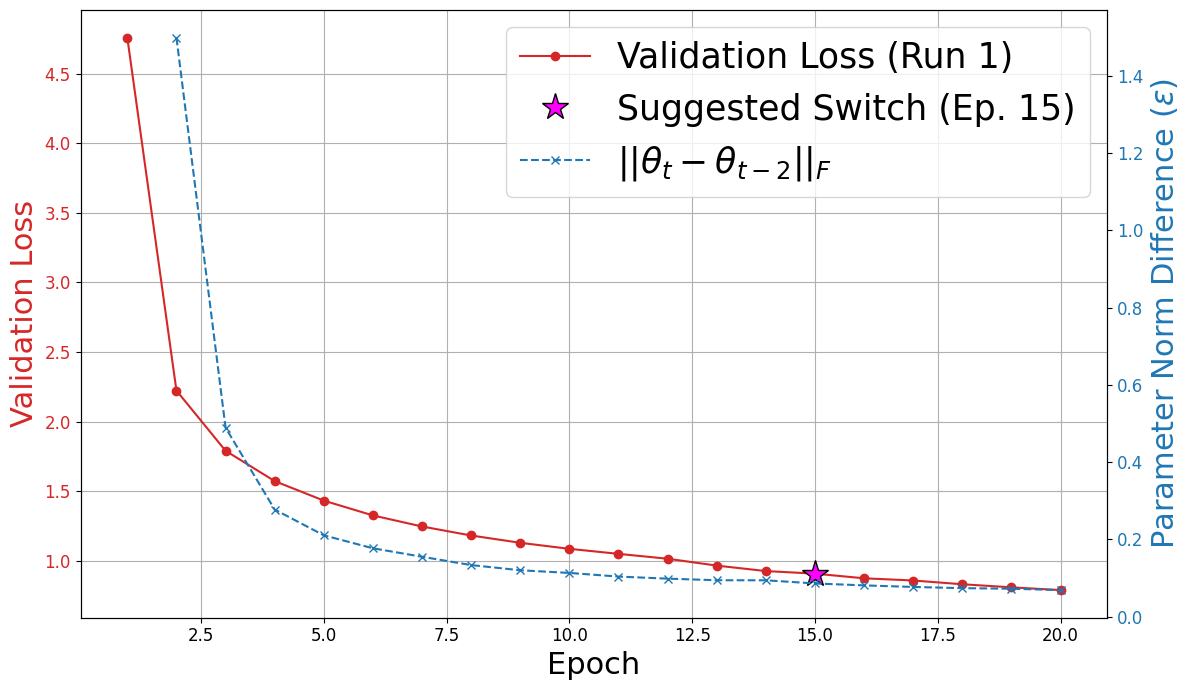

Plot saved as wine_sc_avg_nrmse_p_500_0.007_0.0864.png


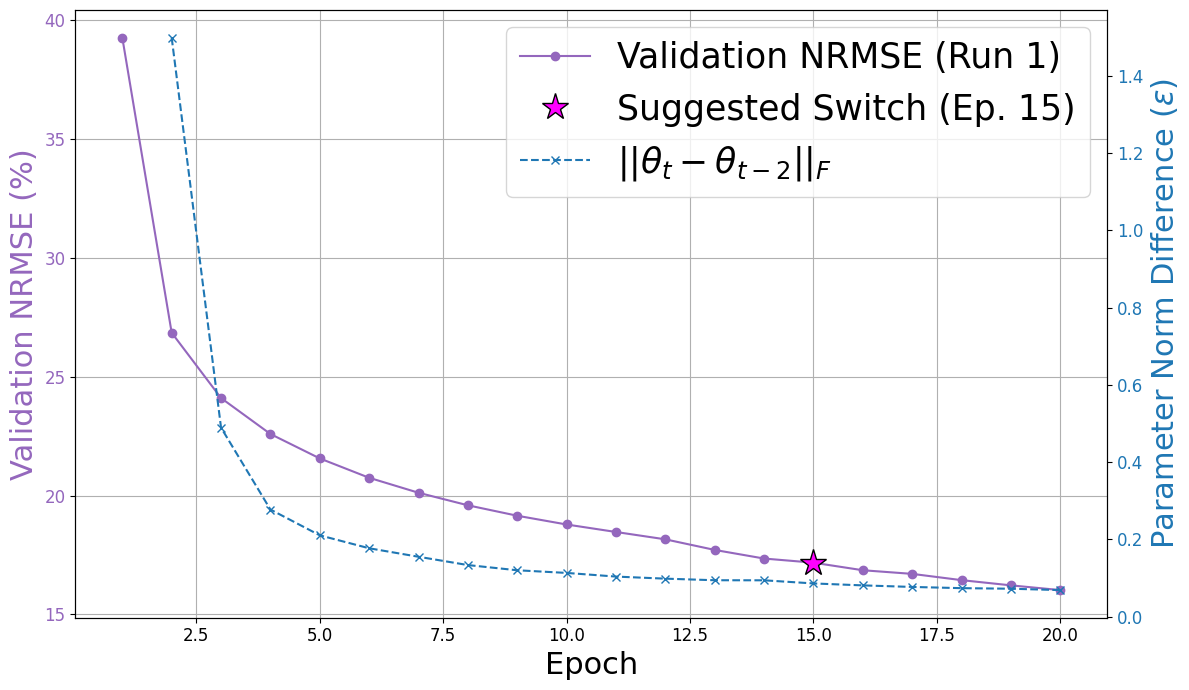

In [56]:
# Encapsulating function for the multi-seed scouting
def run_multiseed_scouting(num_scout_runs, master_key):
    """
    Runs the SGD scouting process over multiple seeds and returns histories for all runs.
    """
    all_scout_histories = []
    scout_run_keys = jax.random.split(master_key, num_scout_runs)

    print(f"--- Starting {num_scout_runs}-Seed Scouting Run ---")

    for i in range(num_scout_runs):
        print(f"  Scouting Run {i+1}/{num_scout_runs}...")
        run_key_init, run_key_loop, run_key_ntk = jax.random.split(scout_run_keys[i], 3)

        scout_initial_params = init_network_params(layer_dims, run_key_init)

        X_scout_ntk_subset = X_train_full
        if max_ntk_scouting_val is not None and max_ntk_scouting_val < X_train_full.shape[0]:
            scout_ntk_indices = jax.random.choice(run_key_ntk, X_train_full.shape[0], shape=(max_ntk_samples_val,), replace=False)
            X_scout_ntk_subset = X_train_full[scout_ntk_indices]

        scout_history = run_sgd_scouting(
            scout_initial_params, X_train_full, Y_train_reg_full, X_val_full, Y_val_reg_full,
            scouting_epochs=scouting_epochs,
            batch_size=min(batch_size_config, X_train_full.shape[0]),
            lr_sgd=scouting_lr,
            key_sgd_loop=run_key_loop,
            switch_method=scouting_method,
            X_ntk_monitor_subset=X_scout_ntk_subset,
            num_classes=num_classes,
            param_norm_window=switch_config['param_norm_window'],
            ntk_norm_window=switch_config['ntk_norm_window']
        )
        all_scout_histories.append(scout_history)

    print("\nAggregating scouting results...")
    avg_scout_history = aggregate_histories(all_scout_histories, metric_keys=['val_loss', 'val_nrmse', 'norm_diff'])

    # Return both the averaged history and the history from the first run for plotting
    return avg_scout_history, all_scout_histories[0]

# --- EXECUTE MULTI-SEED SCOUTING ---
num_scout_runs = 10
avg_scout_history, first_run_history = run_multiseed_scouting(num_scout_runs, scout_key_loop)

# --- Process AVERAGED Data for Threshold Calculation ---
avg_val_loss = np.array(avg_scout_history['val_loss']['mean'])
avg_norm_diff = np.array(avg_scout_history['norm_diff']['mean'])

# --- Process SINGLE-RUN Data for Plotting ---
epochs = np.arange(1, scouting_epochs + 1)
val_loss = np.array(first_run_history['val_loss'])
val_nrmse = np.array(first_run_history['val_nrmse'])
norm_diff = np.array(first_run_history['norm_diff'])

# --- ROBUST THRESHOLD SUGGESTION FROM AVERAGED DATA ---
print("\n--- Suggested Thresholds Based on Averaged Scouting Run ---")
val_loss_diff = np.diff(avg_val_loss)
try:
    initial_drop = avg_val_loss[0] - np.min(avg_val_loss)
    elbow_epoch_idx = np.where(np.abs(val_loss_diff) < 0.01 * initial_drop)[0][0] + 1
except (IndexError, TypeError):
    elbow_epoch_idx = len(avg_val_loss) // 2
print(f"Average validation loss stabilized around epoch {elbow_epoch_idx + 1}.")

stabilization_norms = avg_norm_diff[elbow_epoch_idx:]
stabilization_norms = stabilization_norms[~np.isnan(stabilization_norms)]

recommended_threshold = 0.0
suggested_switch_epoch = scouting_epochs

if stabilization_norms.size > 1:
    if scouting_method == 'param_norm':
        print("\nUsing 'Early Switch' (75th percentile) heuristic for 'param_norm'.")
        recommended_threshold = np.percentile(stabilization_norms, 75)
        switch_config['param_norm_threshold'] = recommended_threshold
    elif scouting_method == 'ntk_norm':
        print("\nUsing 'Late Switch' (25th percentile) heuristic for 'ntk_norm'.")
        recommended_threshold = np.percentile(stabilization_norms, 25)
        switch_config['ntk_norm_threshold'] = recommended_threshold

    try:
        suggested_switch_epoch = np.where(avg_norm_diff < recommended_threshold)[0][0] + 1
    except IndexError:
        print("Threshold was not met on averaged data. Defaulting to last epoch.")
        suggested_switch_epoch = scouting_epochs
else:
    print("Could not automatically determine a threshold.")

print(f"\nRecommended Threshold for '{scouting_method}': {recommended_threshold:.4f}")
print(f"This threshold suggests a switch at Epoch: {suggested_switch_epoch}")

# --- DYNAMIC FILENAME GENERATION ---
dataset_prefix = "wine_sc_avg"
network_width = layer_dims[1]
metric_char = 'n' if scouting_method == 'ntk_norm' else 'p'
filename_template = f"{dataset_prefix}_{{metric_type}}_{metric_char}_{network_width}_{scouting_lr}_{recommended_threshold:.4f}.png"

# --- PLOTTING SETUP ---
# Define font sizes for better readability in a report
TITLE_FONT = 18
LABEL_FONT = 22
LEGEND_FONT = 25
TICK_FONT = 12

# --- PLOTTING (Using data from the FIRST run for visualization) ---
# Get metric values at the suggested switch point for plotting the marker
switch_idx = min(suggested_switch_epoch - 1, len(val_loss) - 1) # Ensure index is valid
loss_at_switch = val_loss[switch_idx]
nrmse_at_switch = val_nrmse[switch_idx] * 100

# Plotting setup based on method
if scouting_method == 'param_norm':
    metric_label, linestyle, marker, color = r'Parameter Norm Difference ($\epsilon$)', '--', 'x', 'tab:blue'
    window_val, title_suffix = switch_config['param_norm_window'], 'Parameter Stability'
    legend_label = fr'$||\theta_t - \theta_{{t-{window_val}}}||_F$'
else: # ntk_norm
    metric_label, linestyle, marker, color = r'NTK Stability ($\delta$)', ':', 's', 'tab:green'
    window_val, title_suffix = switch_config['ntk_norm_window'], 'NTK Stability'
    legend_label = fr'| $||\Theta_t - \Theta_0||_F - ||\Theta_{{t-{window_val}}}-\Theta_0||_F$ |'

# PLOT 1: Validation Loss vs. Stability
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 7))
ax1.plot(epochs, val_loss, color='tab:red', marker='o', label='Validation Loss (Run 1)', zorder=5)
ax1.plot(suggested_switch_epoch, loss_at_switch, '*', color='magenta', markersize=20, label=f'Suggested Switch (Ep. {suggested_switch_epoch})', zorder=10, markeredgecolor='black')
ax1.set_ylabel('Validation Loss', color='tab:red', fontsize=LABEL_FONT)
ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=TICK_FONT)
ax1_twin = ax1.twinx()
ax1_twin.plot(epochs, norm_diff, color=color, marker=marker, linestyle=linestyle, label=legend_label)
ax1_twin.set_ylabel(metric_label, color=color, fontsize=LABEL_FONT)
ax1_twin.tick_params(axis='y', labelcolor=color, labelsize=TICK_FONT)
ax1.set_xlabel('Epoch', fontsize=LABEL_FONT)
ax1.tick_params(axis='x', labelsize=TICK_FONT)
ax1.grid(True)
fig1.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize=LEGEND_FONT)
fig1.tight_layout()
val_filename = filename_template.format(metric_type='val')
plt.savefig(val_filename)
print(f"\nPlot saved as {val_filename}")
plt.show()

# PLOT 2: NRMSE vs. Stability
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 7))
ax2.plot(epochs, val_nrmse * 100, color='tab:purple', marker='o', label='Validation NRMSE (Run 1)', zorder=5)
ax2.plot(suggested_switch_epoch, nrmse_at_switch, '*', color='magenta', markersize=20, label=f'Suggested Switch (Ep. {suggested_switch_epoch})', zorder=10, markeredgecolor='black')
ax2.set_ylabel('Validation NRMSE (%)', color='tab:purple', fontsize=LABEL_FONT)
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize=TICK_FONT)
ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, norm_diff, color=color, marker=marker, linestyle=linestyle, label=legend_label)
ax2_twin.set_ylabel(metric_label, color=color, fontsize=LABEL_FONT)
ax2_twin.tick_params(axis='y', labelcolor=color, labelsize=TICK_FONT)
ax2.set_xlabel('Epoch', fontsize=LABEL_FONT)
ax2.tick_params(axis='x', labelsize=TICK_FONT)
ax2.grid(True)
fig2.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax2.transAxes, fontsize=LEGEND_FONT)
fig2.tight_layout()
nrmse_filename = filename_template.format(metric_type='nrmse')
plt.savefig(nrmse_filename)
print(f"Plot saved as {nrmse_filename}")
plt.show()

Run Main Experiment Loop:

In [28]:
all_runs_histories = {'SGD_Part1': [], 'SGD_Part2': [], 'NTK1_from_Switch': [], 'NTK2_from_Switch': [], 'NTK3_from_Switch': []}
all_runs_times = {'SGD (Part 1)': [], 'SGD (Part 2)': [], 'NTK1': [], 'NTK2': [], 'NTK3': []}
all_runs_test_metrics = {'Params_At_Switch': [], 'SGD_Full_Run': [], 'NTK1_from_Switch': [], 'NTK2_from_Switch': [], 'NTK3_from_Switch': []}
all_runs_switch_epochs = []

for seed in range(num_seeds):
    print(f"\n\n===== RUNNING EXPERIMENT FOR SEED {seed + 1}/{num_seeds} =====")
    key_init_params, key_sgd_part1, key_sgd_part2, key_ntk_subset_shuffle, key_ntk1, key_ntk2, key_ntk3 = run_keys[seed]
    initial_model_params = init_network_params(layer_dims, key_init_params)
    
    # For wine dataset, NTK subset is the full training set
    X_train_ntk_subset = X_train_full
    Y_train_reg_ntk_subset = Y_train_reg_full
    
    # --- Initial SGD Phase (up to switch point) ---
    params_at_switch, history_sgd_part1, time_sgd_part1, epoch_at_switch = run_sgd_monitoring_switch(
        initial_model_params, X_train_full, Y_train_reg_full, X_val_full, Y_val_reg_full,
        max_sgd_epochs=epochs_sgd_total_config, 
        batch_size=min(batch_size_config, X_train_full.shape[0]),
        lr_sgd=lr_sgd_config, key_sgd_loop=key_sgd_part1,
        switch_config=switch_config,
        X_ntk_monitor_subset=X_train_ntk_subset, num_classes=num_classes
    )
    all_runs_switch_epochs.append(epoch_at_switch)
    all_runs_histories['SGD_Part1'].append(history_sgd_part1)
    all_runs_times['SGD (Part 1)'].append(time_sgd_part1)
    test_l_s, test_nrmse_s = evaluate_on_test_jax(params_at_switch, X_test_full, Y_test_reg_full)
    all_runs_test_metrics['Params_At_Switch'].append({'loss': test_l_s, 'nrmse': test_nrmse_s})

    if epoch_at_switch >= epochs_sgd_total_config:
        print(f"WARNING: Switch condition not met for seed {seed+1}. Adjust thresholds or total epochs.")
        # Handle the case where the switch never happens
        # For this experiment, we'll record the full SGD run and skip NTK phases
        all_runs_histories['SGD_Part2'].append({'train_loss': [], 'train_nrmse': [], 'val_loss': [], 'val_nrmse': []}) # Empty history for part 2
        all_runs_times['SGD (Part 2)'].append(0.0)
        all_runs_test_metrics['SGD_Full_Run'].append({'loss': test_l_s, 'nrmse': test_nrmse_s})
        all_runs_test_metrics['NTK1_from_Switch'].append({'loss': np.nan, 'nrmse': np.nan})
        all_runs_test_metrics['NTK2_from_Switch'].append({'loss': np.nan, 'nrmse': np.nan})
        all_runs_test_metrics['NTK3_from_Switch'].append({'loss': np.nan, 'nrmse': np.nan})
        continue # Skip to the next seed

    full_sgd_epochs = epochs_sgd_total_config - epoch_at_switch
    num_ntk_iterations_to_run = epochs_sgd_total_config - epoch_at_switch - 3
    
    # --- Continued SGD Phase ---
    params_after_full_sgd, history_sgd_part2, time_sgd_part2 = run_sgd_epochs(
        copy.deepcopy(params_at_switch), X_train_full, Y_train_reg_full, X_val_full, Y_val_reg_full,
        start_epoch_idx=epoch_at_switch, num_epochs_to_run=full_sgd_epochs,
        batch_size=min(batch_size_config, X_train_full.shape[0]),
        lr_sgd=lr_sgd_config, key_sgd_loop=key_sgd_part2, phase_label="SGD (Part 2)"
    )
    all_runs_histories['SGD_Part2'].append(history_sgd_part2)
    all_runs_times['SGD (Part 2)'].append(time_sgd_part2)
    test_l_full, test_nrmse_full = evaluate_on_test_jax(params_after_full_sgd, X_test_full, Y_test_reg_full)
    all_runs_test_metrics['SGD_Full_Run'].append({'loss': test_l_full, 'nrmse': test_nrmse_full})
    
    # --- NTK Phases ---
    current_ntk_batch_size = min(batch_size_config, X_train_ntk_subset.shape[0])
    if num_ntk_iterations_to_run > 0:
        params_after_ntk1, history_ntk1, time_ntk1 = run_ntk1_phase(
            copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_reg_ntk_subset,
            X_val_full, Y_val_reg_full, num_ntk_iterations_to_run, 
            current_ntk_batch_size, lr_ntk_iterative_config, key_ntk1)
        all_runs_histories['NTK1_from_Switch'].append(history_ntk1)
        all_runs_times['NTK1'].append(time_ntk1)
        test_l_ntk1, test_nrmse_ntk1 = evaluate_on_test_jax(params_after_ntk1, X_test_full, Y_test_reg_full)
        all_runs_test_metrics['NTK1_from_Switch'].append({'loss': test_l_ntk1, 'nrmse': test_nrmse_ntk1})

        params_after_ntk2, history_ntk2, time_ntk2 = run_ntk2_phase(
            copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_reg_ntk_subset,
            X_val_full, Y_val_reg_full, epoch_at_switch, num_ntk_iterations_to_run,
            lr_ntk_iterative_config, taylor_order_ntk2=taylor_order_config)
        all_runs_histories['NTK2_from_Switch'].append(history_ntk2)
        all_runs_times['NTK2'].append(time_ntk2)
        test_l_ntk2, test_nrmse_ntk2 = evaluate_on_test_jax(params_after_ntk2, X_test_full, Y_test_reg_full)
        all_runs_test_metrics['NTK2_from_Switch'].append({'loss': test_l_ntk2, 'nrmse': test_nrmse_ntk2})

    params_after_ntk3, history_ntk3, time_ntk3 = run_ntk3_phase(
        copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_reg_ntk_subset,
        X_val_full, Y_val_reg_full,
        lr_ntk=lr_ntk_iterative_config, # Pass the learning rate
        lambda_ntk3_reg=lambda_ntk3_config, 
        T_factor_ntk3=epochs_sgd_total_config,
        taylor_order_ntk3=taylor_order_config)
    all_runs_histories['NTK3_from_Switch'].append(history_ntk3)
    all_runs_times['NTK3'].append(time_ntk3)
    test_l_ntk3, test_nrmse_ntk3 = evaluate_on_test_jax(params_after_ntk3, X_test_full, Y_test_reg_full)
    all_runs_test_metrics['NTK3_from_Switch'].append({'loss': test_l_ntk3, 'nrmse': test_nrmse_ntk3})



===== RUNNING EXPERIMENT FOR SEED 1/10 =====

--- Starting SGD Phase (Monitoring for Switch using 'param_norm') ---
SGD (Monitoring) Epoch 1 - Train L: 7.1843, NRMSE: 47.46% | Val L: 6.9370, NRMSE: 47.43% (took 0.01s)
SGD (Monitoring) Epoch 2 - Train L: 2.3395, NRMSE: 27.08% | Val L: 2.3352, NRMSE: 27.52% | Param diff norm (k=2) = 1.724596 (took 0.02s)
SGD (Monitoring) Epoch 3 - Train L: 1.7488, NRMSE: 23.42% | Val L: 1.8231, NRMSE: 24.31% | Param diff norm (k=2) = 0.627430 (took 0.02s)
SGD (Monitoring) Epoch 4 - Train L: 1.4676, NRMSE: 21.45% | Val L: 1.5790, NRMSE: 22.63% | Param diff norm (k=2) = 0.304308 (took 0.01s)
SGD (Monitoring) Epoch 5 - Train L: 1.2973, NRMSE: 20.17% | Val L: 1.4303, NRMSE: 21.54% | Param diff norm (k=2) = 0.221894 (took 0.02s)
SGD (Monitoring) Epoch 6 - Train L: 1.1796, NRMSE: 19.23% | Val L: 1.3277, NRMSE: 20.75% | Param diff norm (k=2) = 0.183708 (took 0.02s)
SGD (Monitoring) Epoch 7 - Train L: 1.0939, NRMSE: 18.52% | Val L: 1.2475, NRMSE: 20.11% | Para

Average results:

In [29]:
avg_histories = {}
avg_histories['SGD_Part1'] = aggregate_histories(all_runs_histories['SGD_Part1'], metric_keys=['val_loss', 'val_nrmse'])
avg_histories['SGD_Part2'] = aggregate_histories(all_runs_histories['SGD_Part2'], metric_keys=['train_loss', 'train_nrmse', 'val_loss', 'val_nrmse'])
avg_histories['NTK1_from_Switch'] = aggregate_histories(all_runs_histories['NTK1_from_Switch'], metric_keys=['train_loss', 'train_nrmse', 'val_loss', 'val_nrmse'])
avg_histories['NTK2_from_Switch'] = aggregate_histories(all_runs_histories['NTK2_from_Switch'], metric_keys=['train_loss', 'train_nrmse', 'val_loss', 'val_nrmse'])

ntk3_final_train_losses = [h['train_loss'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['train_loss']]
ntk3_final_val_losses   = [h['val_loss'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['val_loss']]
ntk3_final_train_nrmses = [h['train_nrmse'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['train_nrmse']]
ntk3_final_val_nrmses   = [h['val_nrmse'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['val_nrmse']]

avg_histories['NTK3_from_Switch_Aggregated'] = {
    'train_loss': aggregate_scalar_metrics(ntk3_final_train_losses),
    'val_loss':   aggregate_scalar_metrics(ntk3_final_val_losses),
    'train_nrmse': aggregate_scalar_metrics(ntk3_final_train_nrmses),
    'val_nrmse':  aggregate_scalar_metrics(ntk3_final_val_nrmses)
}

avg_switch_epoch = np.mean(all_runs_switch_epochs)

avg_times = {phase: np.mean(times) for phase, times in all_runs_times.items() if times}
avg_test_metrics = {}
for phase, metrics_list in all_runs_test_metrics.items():
    if metrics_list:
        avg_test_metrics[phase] = {
            'loss_mean': np.nanmean([m.get('loss', np.nan) for m in metrics_list]),
            'loss_std':  np.nanstd([m.get('loss', np.nan) for m in metrics_list]),
            'nrmse_mean': np.nanmean([m.get('nrmse', np.nan) for m in metrics_list]),
            'nrmse_std':  np.nanstd([m.get('nrmse', np.nan) for m in metrics_list])
        }

Plot the results:


Loss plot saved as wine_tr_loss_p_100_0.007_0.0864.png


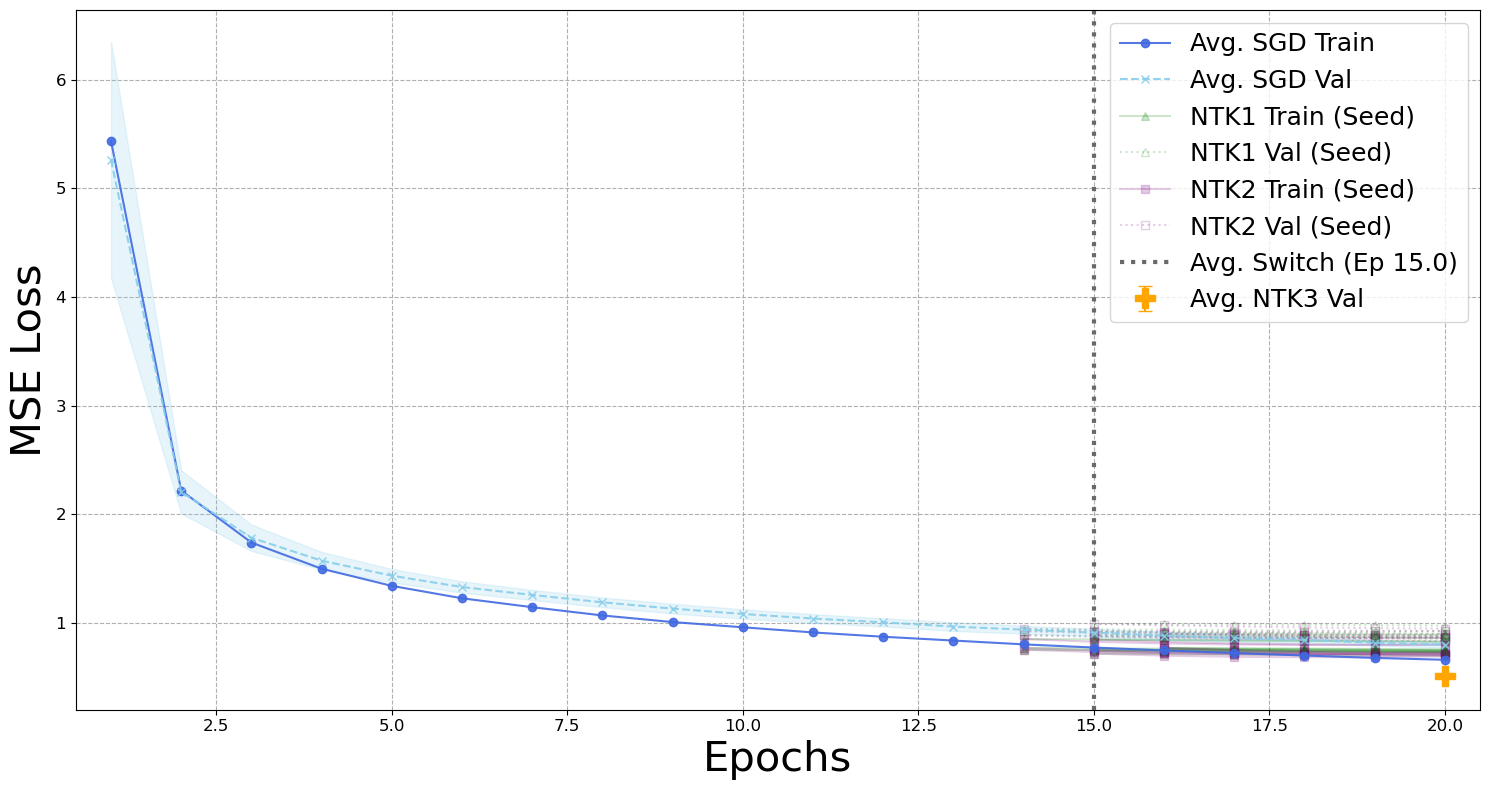

NRMSE plot saved as wine_tr_nrmse_p_100_0.007_0.0864.png


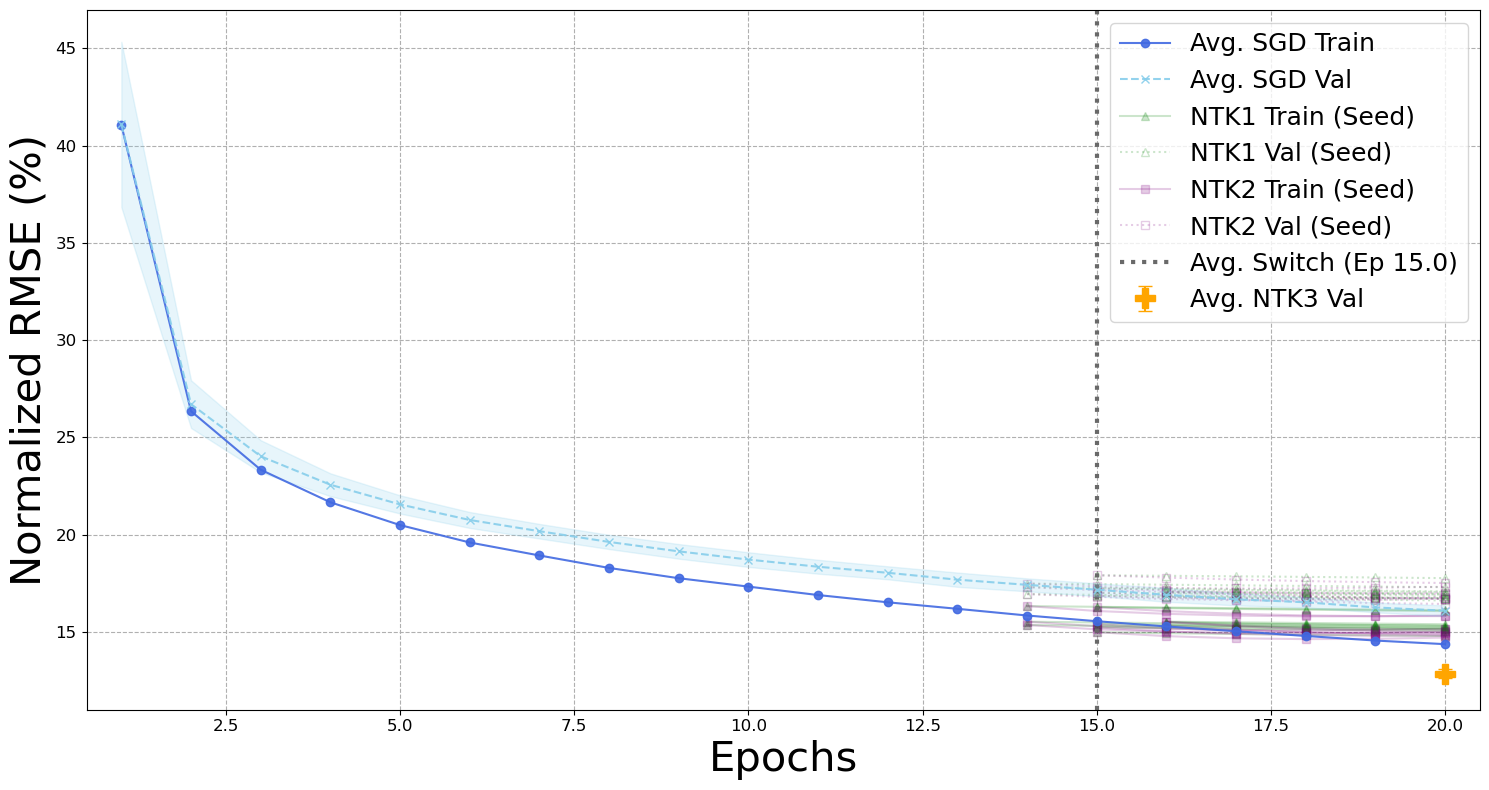

In [46]:
# --- DYNAMIC FILENAME GENERATION FOR MAIN EXPERIMENT ---
dataset_prefix = "wine_tr"
network_width = layer_dims[1]
metric_char = 'n' if switch_config['method'] == 'ntk_norm' else 'p'
threshold = switch_config.get(f"{switch_config['method']}_threshold", 0.0) or 0.0
lr_val = lr_sgd_config
filename_template = f"{dataset_prefix}_{{metric_type}}_{metric_char}_{network_width}_{lr_val}_{threshold:.4f}.png"

# --- PLOTTING SETUP ---
# Define font sizes for better readability in a report
TITLE_FONT = 18
LABEL_FONT = 30
LEGEND_FONT = 18
TICK_FONT = 12

# --- PLOT 1: LOSS TRAJECTORIES ---
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 8))

# --- Create full SGD trajectories for each run, then aggregate. ---
full_sgd_histories = []
metric_keys_to_agg = ['train_loss', 'val_loss', 'train_nrmse', 'val_nrmse']
for h1, h2 in zip(all_runs_histories['SGD_Part1'], all_runs_histories['SGD_Part2']):
    full_sgd_histories.append({
        'train_loss': h1.get('train_loss', []) + h2.get('train_loss', []),
        'val_loss': h1.get('val_loss', []) + h2.get('val_loss', []),
        'train_nrmse': h1.get('train_nrmse', []) + h2.get('train_nrmse', []),
        'val_nrmse': h1.get('val_nrmse', []) + h2.get('val_nrmse', [])
    })
avg_sgd_full = aggregate_histories(full_sgd_histories, metric_keys=metric_keys_to_agg)

# Plot averaged full SGD trajectory (1-based epochs)
num_full_epochs = len(avg_sgd_full['val_loss']['mean'])
epochs_x_full_sgd = np.arange(1, num_full_epochs + 1)

if epochs_x_full_sgd.size > 0:
    ax1.plot(epochs_x_full_sgd, avg_sgd_full['train_loss']['mean'], label='Avg. SGD Train', marker='o', linestyle='-', color='royalblue', alpha=0.9, zorder=10)
    ax1.plot(epochs_x_full_sgd, avg_sgd_full['val_loss']['mean'], label='Avg. SGD Val', marker='x', linestyle='--', color='skyblue', alpha=0.9, zorder=10)
    ax1.fill_between(epochs_x_full_sgd,
                     np.array(avg_sgd_full['val_loss']['mean']) - np.array(avg_sgd_full['val_loss']['std']),
                     np.array(avg_sgd_full['val_loss']['mean']) + np.array(avg_sgd_full['val_loss']['std']),
                     color='skyblue', alpha=0.2, zorder=5)

# Plot Individual NTK Trajectories
for i in range(num_seeds):
    switch_epoch = all_runs_switch_epochs[i]
    start_point_index = switch_epoch - 1

    if start_point_index < len(all_runs_histories['SGD_Part1'][i]['val_loss']):
        start_tl = all_runs_histories['SGD_Part1'][i]['train_loss'][start_point_index]
        start_vl = all_runs_histories['SGD_Part1'][i]['val_loss'][start_point_index]

        for ntk_key, color, marker_style in [('NTK1_from_Switch', 'green', '^'), ('NTK2_from_Switch', 'purple', 's')]:
            if i < len(all_runs_histories[ntk_key]):
                ntk_hist = all_runs_histories[ntk_key][i]
                ntk_len = len(ntk_hist['val_loss'])
                if ntk_len > 0:
                    epochs_x_ntk = np.arange(switch_epoch + 1, switch_epoch + 1 + ntk_len)
                    x_branch = np.insert(epochs_x_ntk, 0, switch_epoch)
                    tl_branch = [start_tl] + ntk_hist['train_loss']
                    vl_branch = [start_vl] + ntk_hist['val_loss']
                    label_prefix = ntk_key.split('_')[0]
                    ax1.plot(x_branch, tl_branch, marker=marker_style, linestyle='-', color=color, alpha=0.2, label=f'{label_prefix} Train (Seed)' if i == 0 else None)
                    ax1.plot(x_branch, vl_branch, marker=marker_style, linestyle=':', color=color, alpha=0.2, label=f'{label_prefix} Val (Seed)' if i == 0 else None, mfc='none')

# Plot NTK3 (One-Shot)
avg_ntk3_loss = avg_histories['NTK3_from_Switch_Aggregated']['val_loss']
ax1.errorbar(epochs_sgd_total_config, avg_ntk3_loss['mean'], yerr=avg_ntk3_loss['std'], fmt='P', markersize=15, color='orange', label='Avg. NTK3 Val', zorder=11, capsize=5)

# Plot Average Switch Point
avg_switch_epoch_plot = np.mean(all_runs_switch_epochs)
ax1.axvline(x=avg_switch_epoch_plot, color='dimgray', linestyle=':', linewidth=3, label=f'Avg. Switch (Ep {avg_switch_epoch_plot:.1f})')

# Final Touches for Loss Plot
ax1.set_ylabel("MSE Loss", fontsize=LABEL_FONT)
ax1.set_xlabel("Epochs", fontsize=LABEL_FONT)
ax1.legend(fontsize=LEGEND_FONT, loc='best')
ax1.grid(True, which='both', linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=TICK_FONT)
ax1.set_xlim(left=0.5, right=epochs_sgd_total_config + 0.5)
fig1.tight_layout()
loss_filename = filename_template.format(metric_type='loss')
plt.savefig(loss_filename)
print(f"\nLoss plot saved as {loss_filename}")
plt.show()


# --- PLOT 2: NRMSE TRAJECTORIES ---
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 8))

# Plot averaged full SGD trajectory for NRMSE
if epochs_x_full_sgd.size > 0:
    ax2.plot(epochs_x_full_sgd, np.array(avg_sgd_full['train_nrmse']['mean'])*100, label='Avg. SGD Train', marker='o', linestyle='-', color='royalblue', alpha=0.9, zorder=10)
    ax2.plot(epochs_x_full_sgd, np.array(avg_sgd_full['val_nrmse']['mean'])*100, label='Avg. SGD Val', marker='x', linestyle='--', color='skyblue', alpha=0.9, zorder=10)
    ax2.fill_between(epochs_x_full_sgd,
                     (np.array(avg_sgd_full['val_nrmse']['mean']) - np.array(avg_sgd_full['val_nrmse']['std']))*100,
                     (np.array(avg_sgd_full['val_nrmse']['mean']) + np.array(avg_sgd_full['val_nrmse']['std']))*100,
                     color='skyblue', alpha=0.2, zorder=5)

# Plot Individual NTK Trajectories for NRMSE
for i in range(num_seeds):
    switch_epoch = all_runs_switch_epochs[i]
    start_point_index = switch_epoch - 1

    if start_point_index < len(all_runs_histories['SGD_Part1'][i]['val_nrmse']):
        start_tnrmse = all_runs_histories['SGD_Part1'][i]['train_nrmse'][start_point_index]
        start_vnrmse = all_runs_histories['SGD_Part1'][i]['val_nrmse'][start_point_index]

        for ntk_key, color, marker_style in [('NTK1_from_Switch', 'green', '^'), ('NTK2_from_Switch', 'purple', 's')]:
            if i < len(all_runs_histories[ntk_key]):
                ntk_hist = all_runs_histories[ntk_key][i]
                ntk_len = len(ntk_hist['val_nrmse'])
                if ntk_len > 0:
                    epochs_x_ntk = np.arange(switch_epoch + 1, switch_epoch + 1 + ntk_len)
                    x_branch = np.insert(epochs_x_ntk, 0, switch_epoch)
                    tnrmse_branch = np.array([start_tnrmse] + ntk_hist['train_nrmse']) * 100
                    vnrmse_branch = np.array([start_vnrmse] + ntk_hist['val_nrmse']) * 100
                    label_prefix = ntk_key.split('_')[0]
                    ax2.plot(x_branch, tnrmse_branch, marker=marker_style, linestyle='-', color=color, alpha=0.2, label=f'{label_prefix} Train (Seed)' if i == 0 else None)
                    ax2.plot(x_branch, vnrmse_branch, marker=marker_style, linestyle=':', color=color, alpha=0.2, label=f'{label_prefix} Val (Seed)' if i == 0 else None, mfc='none')

# Plot NTK3 (One-Shot) for NRMSE
avg_ntk3_nrmse = avg_histories['NTK3_from_Switch_Aggregated']['val_nrmse']
ax2.errorbar(epochs_sgd_total_config, avg_ntk3_nrmse['mean']*100, yerr=avg_ntk3_nrmse['std']*100, fmt='P', markersize=15, color='orange', label='Avg. NTK3 Val', zorder=11, capsize=5)

# Plot Average Switch Point
ax2.axvline(x=avg_switch_epoch_plot, color='dimgray', linestyle=':', linewidth=3, label=f'Avg. Switch (Ep {avg_switch_epoch_plot:.1f})')

# Final Touches for NRMSE Plot
ax2.set_ylabel("Normalized RMSE (%)", fontsize=LABEL_FONT)
ax2.set_xlabel("Epochs", fontsize=LABEL_FONT)
ax2.legend(fontsize=LEGEND_FONT, loc='best')
ax2.grid(True, which='both', linestyle='--')
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONT)
ax2.set_xlim(left=0.5, right=epochs_sgd_total_config + 0.5)
fig2.tight_layout()
nrmse_filename = filename_template.format(metric_type='nrmse')
plt.savefig(nrmse_filename)
print(f"NRMSE plot saved as {nrmse_filename}")
plt.show()

Summarize the results:

In [91]:
print("\\n--- Averaged Final Test Metrics & Runtimes (across {} seeds) ---".format(num_seeds))
print(f"Switch Method: {switch_config['method']}")
print(f"Average Switch Epoch: {avg_switch_epoch:.2f} ± {np.std(all_runs_switch_epochs):.2f}")
print(f"\\nSGD Part 1 (Monitoring Phase): Avg. Time: {avg_times.get('SGD (Part 1)',0.0):.2f}s")
if 'Params_At_Switch' in avg_test_metrics:
    m = avg_test_metrics['Params_At_Switch']
    print(f"  Params at Switch Point Test: Avg. Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. NRMSE: {m['nrmse_mean']*100:.2f}% ± {m['nrmse_std']*100:.2f}%")

print(f"SGD Part 2 (Post-Switch Phase): Avg. Time: {avg_times.get('SGD (Part 2)',0.0):.2f}s")

if 'SGD_Full_Run' in avg_test_metrics:
    m = avg_test_metrics['SGD_Full_Run']
    total_avg_sgd_time = avg_times.get('SGD (Part 1)', 0.0) + avg_times.get('SGD (Part 2)', 0.0)
    print(f"SGD Full Run ({epochs_sgd_total_config} total epochs): Avg. Total Time: {total_avg_sgd_time:.2f}s")
    print(f"  Test: Avg. Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. NRMSE: {m['nrmse_mean']*100:.2f}% ± {m['nrmse_std']*100:.2f}%")

print("") # Add a blank line for readability

for phase_key_suffix in ['NTK1', 'NTK2', 'NTK3']:
    full_phase_key = f'{phase_key_suffix}_from_Switch'
    if full_phase_key in avg_test_metrics:
        m = avg_test_metrics[full_phase_key]
        avg_time = avg_times.get(phase_key_suffix, 0.0)
        print(f"Phase: {phase_key_suffix:<5} (from switch) | Avg. Test Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. Test NRMSE: {m['nrmse_mean']*100:.2f}% ± {m['nrmse_std']*100:.2f}% | Avg. Time: {avg_time:.2f}s")

\n--- Averaged Final Test Metrics & Runtimes (across 10 seeds) ---
Switch Method: ntk_norm
Average Switch Epoch: 7.10 ± 1.37
\nSGD Part 1 (Monitoring Phase): Avg. Time: 22.30s
  Params at Switch Point Test: Avg. Loss: 1.1446 ± 0.0930, Avg. NRMSE: 18.81% ± 0.77%
SGD Part 2 (Post-Switch Phase): Avg. Time: 0.68s
SGD Full Run (20 total epochs): Avg. Total Time: 22.98s
  Test: Avg. Loss: 0.6639 ± 0.0072, Avg. NRMSE: 14.33% ± 0.08%

Phase: NTK1  (from switch) | Avg. Test Loss: 1.0360 ± 0.0659, Avg. Test NRMSE: 17.90% ± 0.57% | Avg. Time: 16.72s
Phase: NTK2  (from switch) | Avg. Test Loss: 1.9716 ± 0.4176, Avg. Test NRMSE: 24.57% ± 2.59% | Avg. Time: 7.38s
Phase: NTK3  (from switch) | Avg. Test Loss: 0.4617 ± 0.0300, Avg. Test NRMSE: 11.95% ± 0.38% | Avg. Time: 3.94s
